In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Ejemplo de Análisis de Sensibilidad
import yfinance as yf
from scipy.stats import gaussian_kde

In [2]:
df_original = yf.Ticker('NQ=F')
df_original = df_original.history(start='2010-01-01', end='2024-01-01')

### Función de backtest para la estrategia de medias móviles con cálculo de Sharpe

In [3]:
def backtest_strategy(data, sma_1, sma_2):
    df = data.copy()
    df['SMA_1'] = df['Close'].rolling(window=sma_1).mean()
    df['SMA_2'] = df['Close'].rolling(window=sma_2).mean()

    df['Signal'] = 0
    df.loc[df['SMA_1'] > df['SMA_2'], 'Signal'] = 1
    df.loc[df['SMA_1'] < df['SMA_2'], 'Signal'] = -1

    df['Position'] = df['Signal'].shift()
    df['Strategy_Returns'] = df['Position'] * df['Close'].pct_change()

    df.dropna(inplace=True)

    # Calcular el rendimiento total
    total_return = (df['Strategy_Returns'] + 1).prod() - 1

    # Calcular el ratio de Sharpe (asumimos rendimiento libre de riesgo = 0)
    avg_return = df['Strategy_Returns'].mean()
    risk = df['Strategy_Returns'].std()
    sharpe_ratio = avg_return / risk if risk != 0 else np.nan

    return total_return, sharpe_ratio

### Parámetros base optimizados


In [ ]:
base_sma_1 = 50
base_sma_2 = 200

### Rango de variación para el análisis de sensibilidad


In [5]:
sma_1_range = [45, 50, 55]
sma_2_range = [195, 200, 205]

**Propósito del análisis de sensibilidad**

El análisis de sensibilidad evalúa cómo varían los resultados de la estrategia (en este caso, el ratio de Sharpe) al modificar ligeramente los parámetros de entrada. Esto es crucial porque:

1. Evita el sobreajuste (overfitting): Una estrategia que depende demasiado de un conjunto específico de parámetros podría no ser robusta.
2. Evalúa la robustez: Si pequeñas variaciones en los parámetros producen resultados consistentes, la estrategia es más confiable.
3. Identifica la sensibilidad: Determina qué tan dependiente es la estrategia de los parámetros seleccionados (en este caso, SMA_1 y SMA_2).

### Realizar el análisis de sensibilidad


In [6]:
sens_results = []

for sma_1 in sma_1_range:
    for sma_2 in sma_2_range:
        total_return, sharpe_ratio = backtest_strategy(df_original, sma_1, sma_2)
        sens_results.append((sma_1, sma_2, total_return, sharpe_ratio))
        print(f'SMA_1: {sma_1}, SMA_2: {sma_2} - Rendimiento Total: {total_return:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}')


SMA_1: 45, SMA_2: 195 - Rendimiento Total: 238.90%, Sharpe Ratio: 0.03
SMA_1: 45, SMA_2: 200 - Rendimiento Total: 186.71%, Sharpe Ratio: 0.03
SMA_1: 45, SMA_2: 205 - Rendimiento Total: 176.37%, Sharpe Ratio: 0.03
SMA_1: 50, SMA_2: 195 - Rendimiento Total: 340.99%, Sharpe Ratio: 0.04
SMA_1: 50, SMA_2: 200 - Rendimiento Total: 308.13%, Sharpe Ratio: 0.04
SMA_1: 50, SMA_2: 205 - Rendimiento Total: 248.82%, Sharpe Ratio: 0.04
SMA_1: 55, SMA_2: 195 - Rendimiento Total: 266.40%, Sharpe Ratio: 0.04
SMA_1: 55, SMA_2: 200 - Rendimiento Total: 269.51%, Sharpe Ratio: 0.04
SMA_1: 55, SMA_2: 205 - Rendimiento Total: 240.53%, Sharpe Ratio: 0.03


In [7]:
# Ordenar los resultados por rendimiento
sens_results.sort(key=lambda x: x[2], reverse=True)

In [8]:
# Calcular la desviación estándar de los Sharpe Ratios
sharpe_ratios = [res[3] for res in sens_results if not np.isnan(res[3])]
sharpe_std = np.std(sharpe_ratios)

In [9]:
# Mostrar los resultados
print("\nResultados del análisis de sensibilidad (ordenados por rendimiento):")
for res in sens_results:
    print(f'SMA_1: {res[0]}, SMA_2: {res[1]} - Rendimiento Total: {res[2]:.2%}, Sharpe Ratio: {res[3]:.2f}')

print(f"\nDesviación estándar de los Sharpe Ratios: {sharpe_std:.4f}")



Resultados del análisis de sensibilidad (ordenados por rendimiento):
SMA_1: 50, SMA_2: 195 - Rendimiento Total: 340.99%, Sharpe Ratio: 0.04
SMA_1: 50, SMA_2: 200 - Rendimiento Total: 308.13%, Sharpe Ratio: 0.04
SMA_1: 55, SMA_2: 200 - Rendimiento Total: 269.51%, Sharpe Ratio: 0.04
SMA_1: 55, SMA_2: 195 - Rendimiento Total: 266.40%, Sharpe Ratio: 0.04
SMA_1: 50, SMA_2: 205 - Rendimiento Total: 248.82%, Sharpe Ratio: 0.04
SMA_1: 55, SMA_2: 205 - Rendimiento Total: 240.53%, Sharpe Ratio: 0.03
SMA_1: 45, SMA_2: 195 - Rendimiento Total: 238.90%, Sharpe Ratio: 0.03
SMA_1: 45, SMA_2: 200 - Rendimiento Total: 186.71%, Sharpe Ratio: 0.03
SMA_1: 45, SMA_2: 205 - Rendimiento Total: 176.37%, Sharpe Ratio: 0.03

Desviación estándar de los Sharpe Ratios: 0.0033


In [10]:
# Calcular el Sharpe Ratio original
_, sharpe_original = backtest_strategy(df_original, base_sma_1, base_sma_2)

### Graficar la curva de densidad del Sharpe Ratio


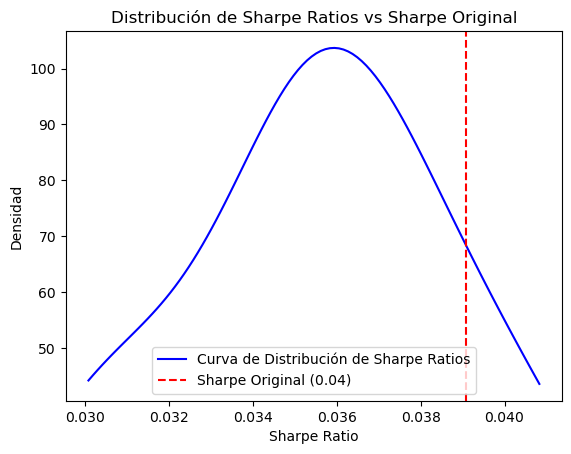

In [13]:
kde = gaussian_kde(sharpe_ratios)
x_range = np.linspace(min(sharpe_ratios), max(sharpe_ratios), 100)
plt.plot(x_range, kde(x_range), label='Curva de Distribución de Sharpe Ratios', color='b')
# Añadir la línea del Sharpe Ratio original
plt.axvline(x=sharpe_original, color='r', linestyle='--', label=f'Sharpe Original ({sharpe_original:.2f})')

plt.title('Distribución de Sharpe Ratios vs Sharpe Original')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Densidad')
plt.legend()
plt.show()
